# Mini Lab: SVM and Logistic Regression Modeling

### Teammates: Chad Kwong, Erin McClure-Price, Alex Lopez, Chris Haub

## Initial loading of dataset and all related packages

The first step was to load necessary packages and the dataset. In addition, we created a series of variables for indexing both the continuous and categorical variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn import svm
import glob
import os

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
catCol = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
          'contact', 'month', 'day_of_week', 'poutcome', 'y']

The next step was to drop entries with missing values, this removed #### rows leaving 30,488 rows for analysis. In addition, we removed the 'default' column because it consisted of entirely 'no' responses and a total of 3 'yes' responses.

In [2]:
bankData2 = bankData.dropna()
#remove 'default' column
bankData2.drop(['default'], axis=1)
bankData2.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


We double checked the dataset to ensure that all missing values had been removed.

In [3]:
# checked for missing values, no missing values
bankData2.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Checking the shape of the data showed that we had a total of 30,488 rows and 21 attributes in our cleaned dataset.

In [4]:
bankData2.shape

(30488, 21)

## Building Model

Before we could build a model, we needed to create a dataframe with the target variable, y, which was whether a customer decided to take on a long term deposit.

In [5]:
#define the target variable
y = bankData2.y
y.head()

0    no
2    no
3    no
4    no
6    no
Name: y, dtype: object

The dataset is a mixture of both continuous, numeric, and categorical data, therefore we chose to separate the categorical attributes into a separate dataframe and apply One Hot Encoding to convert categorical entries to numeric data. The converted dataframe was concatenated back into the original dataframe and the original attributes were removed.

In [6]:
# one hot encoding of ALL categorical variables

# pd.concat([*]], axis=1) // this line of code concatenates all the data frames in the [*] list
# [** for col in categ_features] // this steps through each feature in categ_features and 
#                                //   creates a new element in a list based on the output of **
# pd.get_dummies(df_imputed[col],prefix=col) // this creates a one hot encoded dataframe of the variable=col (like code above)

categ_features = ['job','marital','education','default','housing','loan','contact','month','poutcome'];

OneHotDF = pd.concat([pd.get_dummies(bankData2[col],prefix=col,drop_first=True) for col in categ_features], axis=1)

OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_nonexistent,poutcome_success
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Logistic Regression

In [7]:
#Building a logistic regression model with default values for parameters

# Separating out the features
X = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1)
X = X.values

# Separating out target
Y = bankData2.pop("y")
Y = Y.values.ravel()

#apply cross validation, using 80/20 train/test splitting
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=2, test_size=0.20, random_state=0)

#apply standard scaling: to yield standard normally distributed data
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#apply logistic regression
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv.split(X,Y): 
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    
    X_test = X[test_indices]
    Y_test = Y[test_indices] 
    
    X_train_scaled = scl_obj.fit_transform(X_train) # apply to training
    X_test_scaled = scl_obj.transform(X_test) 
    
    regEstimator.fit(X_train_scaled, Y_train)  # train object
    y_hat = regEstimator.predict(X_test_scaled) # get test set precitions
    acc = mt.accuracy_score(Y_test,y_hat)
    conf = mt.confusion_matrix(Y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print('accuracy:', acc )
    print("confusion matrix\n",conf)
    #print(conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time
    

# https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb


/Users/chadkwong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


====Iteration 0  ====
accuracy: 0.9017710724827812
confusion matrix
 [[5172  178]
 [ 421  327]]
====Iteration 1  ====
accuracy: 0.9034109544112824
confusion matrix
 [[5166  160]
 [ 429  343]]


## Interpretting weights

In [8]:
# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object


# train the reusable logisitc regression model on the training data
lr_clf.fit(X_train,Y_train)  # train object
y_hat = lr_clf.predict(X_test) # get test set precitions

# interpret the weights

# iterate over the coefficients
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = bankData2.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])
    
# does this look correct? 
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

age has weight of 0.0029935167943839023
job has weight of 0.004524379826722064
marital has weight of -0.0497907369077171
education has weight of -0.0016520765943134385
default has weight of -0.15773391238800266
housing has weight of -0.26297089635945875
loan has weight of 0.3457759098631551
contact has weight of 0.023618001879698255
month has weight of -0.21426656003986816
day_of_week has weight of -0.006399511158191971
duration has weight of -0.12734943212771677
campaign has weight of -0.019228265991040532
pdays has weight of 0.0025566369103869986
previous has weight of 0.01400562311608565
poutcome has weight of 0.06452989655081218
emp.var.rate has weight of -0.0010876722990246829
cons.price.idx has weight of -0.043640073354850976
cons.conf.idx has weight of 0.04004979350710377
euribor3m has weight of 0.019071001067514425
nr.employed has weight of 0.004740544840706198


These weight interpretations are not neccessarily interpretable because of the values we had. Very large attribute values could just as easily be assigned a higher weight. Instead, let's normalize the feature values so that all the attributes are on the same dynamic range. Once we normalize the attributes, the weights should have magnitudes that reflect their poredictive power in the logistic regression model.

In [9]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05, solver='liblinear') # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,Y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,bankData2.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

accuracy: 0.9025910134470319
[[5166  160]
 [ 434  338]]
housing has weight of -1.2101311757986828
day_of_week has weight of -0.30982894782325293
education has weight of -0.19779145132584777
marital has weight of -0.09421066769672895
duration has weight of -0.07948796003510064
cons.price.idx has weight of -0.039411957320554636
default has weight of -0.03887986224132142
campaign has weight of -0.026317928291100617
age has weight of -0.024767656952667565
emp.var.rate has weight of -0.01126730406961087
nr.employed has weight of -0.001050756806464229
euribor3m has weight of 0.002811206301125258
previous has weight of 0.014187588554151557
pdays has weight of 0.01815762463685661
cons.conf.idx has weight of 0.029261904839449286
contact has weight of 0.058323020869565985
poutcome has weight of 0.08318584797280619
month has weight of 0.14899981635692824
loan has weight of 0.4826115233716718
job has weight of 1.1548816917736084


## Look at code below

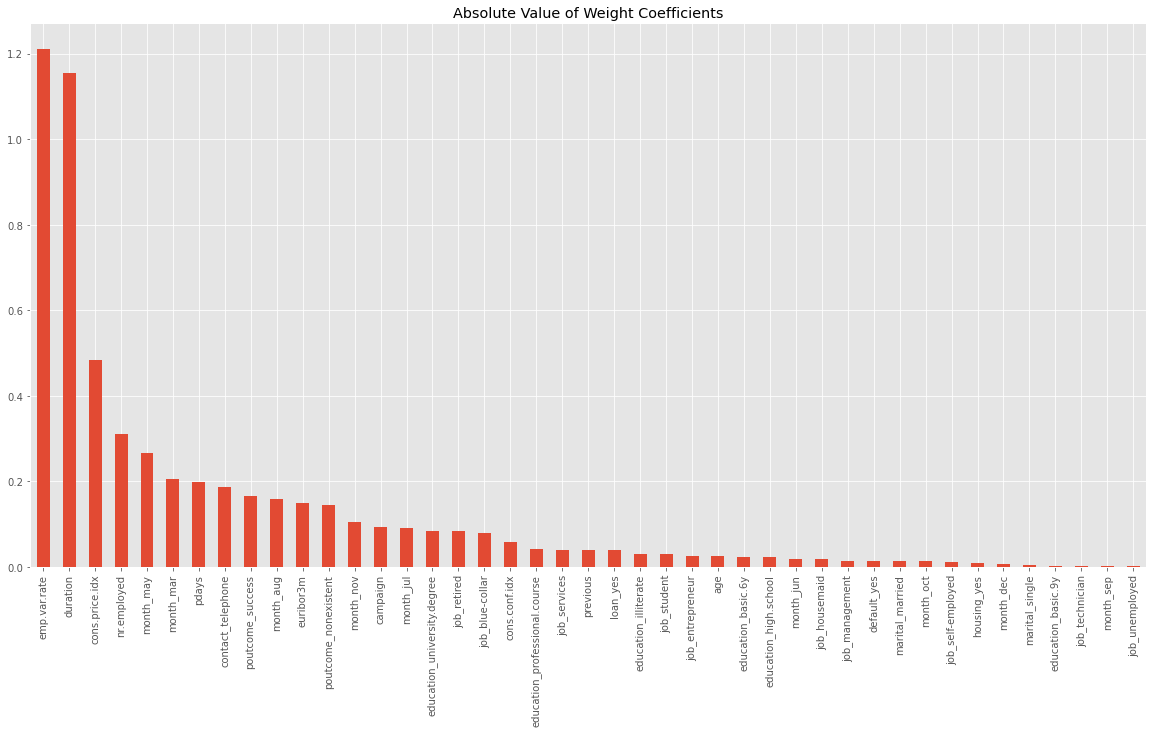

In [10]:
# Creating a list of labels for plots
columns = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=0).columns

%matplotlib inline
plt.style.use('ggplot')
#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

weights = abs(pd.Series(lr_clf.coef_[0],index=columns)).sort_values(ascending=False)
weights.plot(kind='bar', title="Absolute Value of Weight Coefficients")
plt.show()

## Support Vector Machines

In [11]:
from sklearn.svm import SVC

#Training the model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto')
svm_clf.fit(X_train_scaled, Y_train)

#Generating Predictions
y_hat = svm_clf.predict(X_test_scaled)

#calculating accuracy and confusion matrix and printing the two
acc = mt.accuracy_score(Y_test,y_hat)
conf = mt.confusion_matrix(Y_test,y_hat)
print('accuracy:', acc )
print("Confusion Matrix:\n",conf,"\n")

#Printing Support Vector shapes and information
print("The shape of the support vectors is ",svm_clf.support_vectors_.shape)
print("The indices of support vectors are",svm_clf.support_.shape)
print("The numbers of support vectors for each class are",svm_clf.n_support_)

accuracy: 0.8961954739258773
Confusion Matrix:
 [[5175  151]
 [ 482  290]] 

The shape of the support vectors is  (5892, 43)
The indices of support vectors are (5892,)
The numbers of support vectors for each class are [3075 2817]


The coefficient values are : 
 [[-2.47676570e-02  1.15488169e+00 -9.42106677e-02 -1.97791451e-01
  -3.88798622e-02 -1.21013118e+00  4.82611523e-01  5.83230209e-02
   1.48999816e-01 -3.09828948e-01 -7.94879600e-02 -2.63179283e-02
   1.81576246e-02  1.41875886e-02  8.31858480e-02 -1.12673041e-02
  -3.94119573e-02  2.92619048e-02  2.81120630e-03 -1.05075681e-03
  -1.39310946e-02  3.94533235e-03  2.37808175e-02 -3.32839013e-03
   2.22432111e-02  3.09796100e-02  4.23650657e-02  8.36090140e-02
  -1.41706954e-02 -9.34466678e-03 -3.83986358e-02 -1.87028274e-01
   1.59793131e-01  7.60045744e-03  8.99847405e-02  1.93963330e-02
   2.06526956e-01 -2.65928425e-01 -1.04978808e-01  1.30884744e-02
  -1.06366661e-03  1.45298399e-01  1.66933312e-01]]


<AxesSubplot:title={'center':'Absolute Value of Weight Coefficients'}>

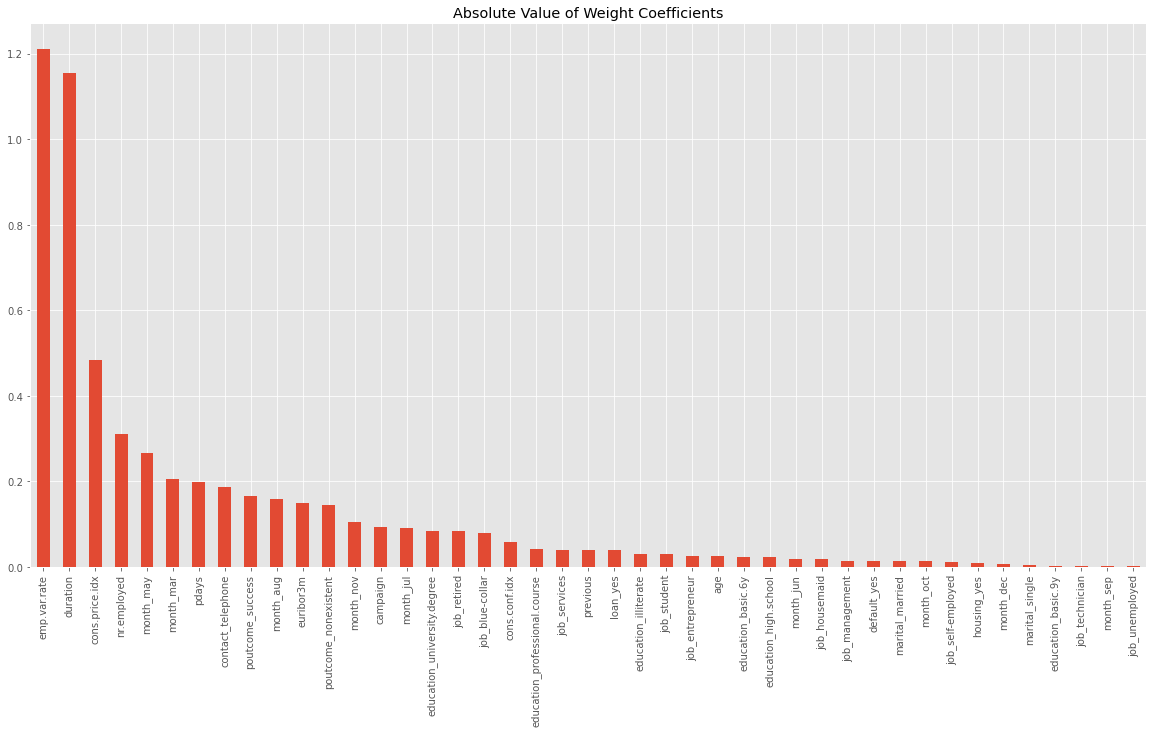

In [12]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print("The coefficient values are : \n",lr_clf.coef_)
plt.rcParams["figure.figsize"] = (20,10)
weights = abs(pd.Series(lr_clf.coef_[0],index=columns)).sort_values(ascending=False)
weights.plot(kind='bar', title="Absolute Value of Weight Coefficients")

<ipython-input-13-5d98bcc1931f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankData2["y"] = Y # also add it back in for the original data


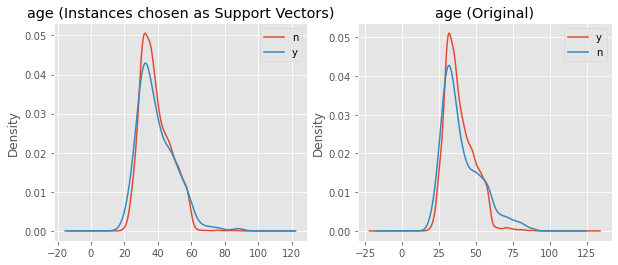

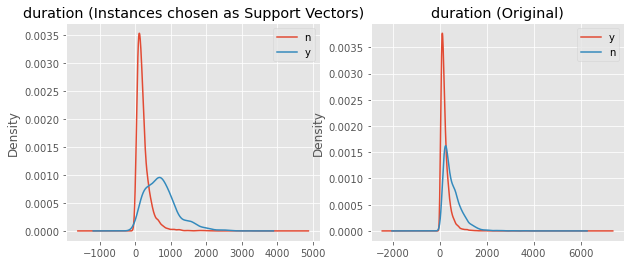

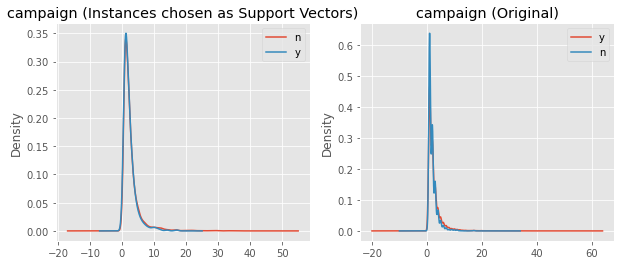

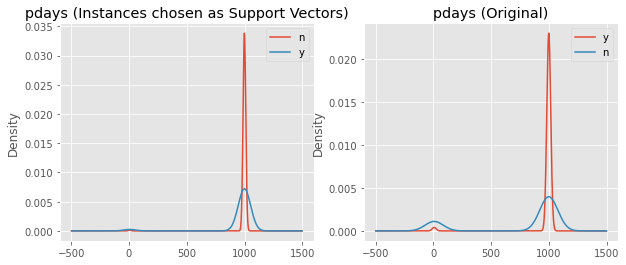

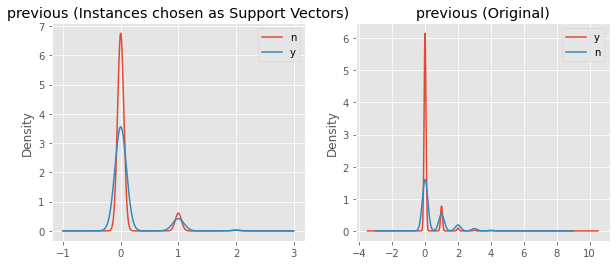

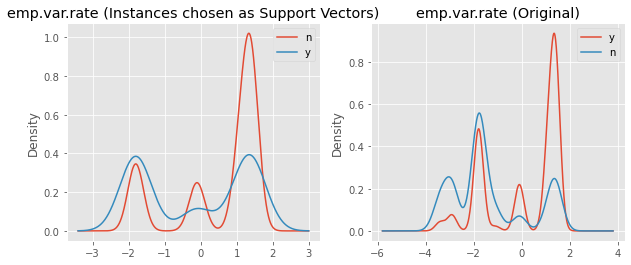

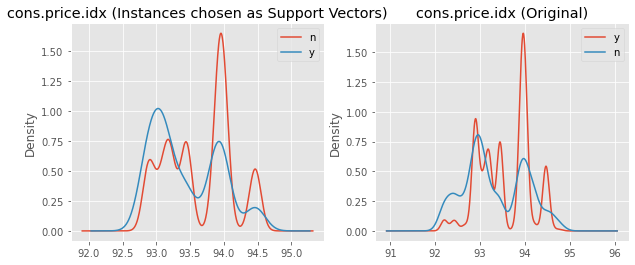

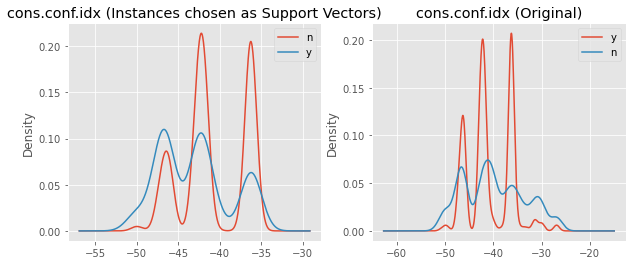

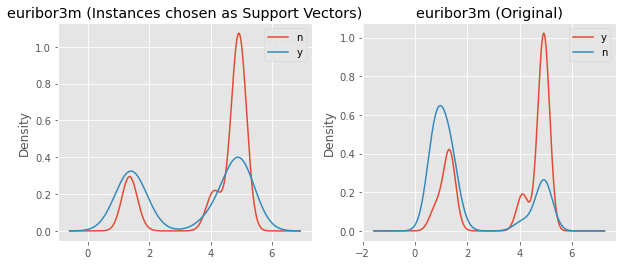

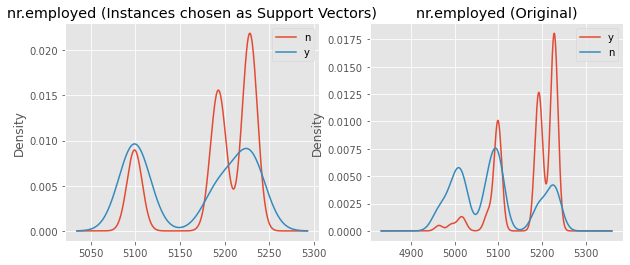

In [13]:
# make a dataframe of the training data
df_tested_on = bankData2.iloc[train_indices].copy() # saved from above, the indices chosen for training
# getting the support vectors from the trained model
df_support = bankData2.iloc[svm_clf.support_,:].copy()

#Adding y column back into datasets
df_support["y"] = Y[svm_clf.support_] 
bankData2["y"] = Y # also add it back in for the original data

# group the original data and the support vectors
df_grouped_support = df_support.groupby(["y"])
df_grouped = bankData2.groupby(["y"])

#plotting KDE of all continuous variables
for v in bankData[conCol].columns:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(["n","y"])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['y','n'])
    plt.title(v+' (Original)')
    


You can also look at joint plots of the data and see how relationships have changed. 
**(Hint hint for the min-lab assignment--this would be a nice analysis of the support vectors.)**

## Gradient Based Alternatives

In [14]:
# # load another dataset (large) and train using various methods of gradient (and mini-batch)
# from __future__ import print_function

# 

In [15]:
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb
%%time
# use some compact notation for creating a linear SVM classifier with stichastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    #Generating predictions
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    #Generating Confusion Matrix and Accuracy Score
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('SVM:', acc)

SVM: 0.8866841587405707
CPU times: user 776 ms, sys: 36.1 ms, total: 812 ms
Wall time: 325 ms


In [16]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,Y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),Y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8950475565759265
CPU times: user 1.17 s, sys: 37.3 ms, total: 1.21 s
Wall time: 337 ms


In [17]:
%%time
# now lets use some of what we know from this class to reduce the dimensionality of the set
from sklearn.decomposition import PCA
n_components = 43

pca = PCA(n_components=n_components, svd_solver='randomized')

iterations = 150
log_sgd = SGDClassifier(
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', max_iter=iterations, n_jobs=-1, penalty='l2')

# you could also set this up in a pipeline
for train_idx, test_idx in cv.split(X,Y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),Y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(Y[test_idx],yhat)
    acc = mt.accuracy_score(Y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.9022630370613316
CPU times: user 3.87 s, sys: 141 ms, total: 4.01 s
Wall time: 1.78 s


[[5137  189]
 [ 407  365]]


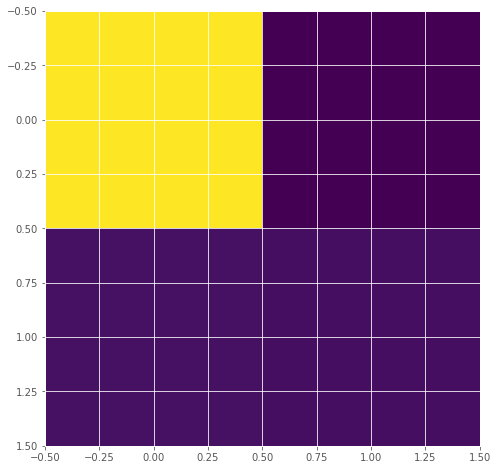

In [18]:
f = plt.figure(figsize=(8,8))
plt.imshow(conf)

#Confusion Matrix
print(conf)